# Predicting Ads Click-Through Rate (CTR)

In [27]:


"""# Predicting Ads Click-Through Rate (CTR)

## Introduction

Click-Through Rate (CTR) prediction estimates the probability of a user clicking on an advertisement. This is crucial for optimizing ad campaigns, improving targeting, and maximizing ROI. This script uses machine learning models (XGBoost, Random Forest, Logistic Regression) with cross-validation, hyperparameter tuning, and exploratory data analysis (EDA) to predict CTR and compare model performance.

## Dependencies
"""

# Install required packages
# !pip install faker

# Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
import warnings
import joblib
import os

# Ignore warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

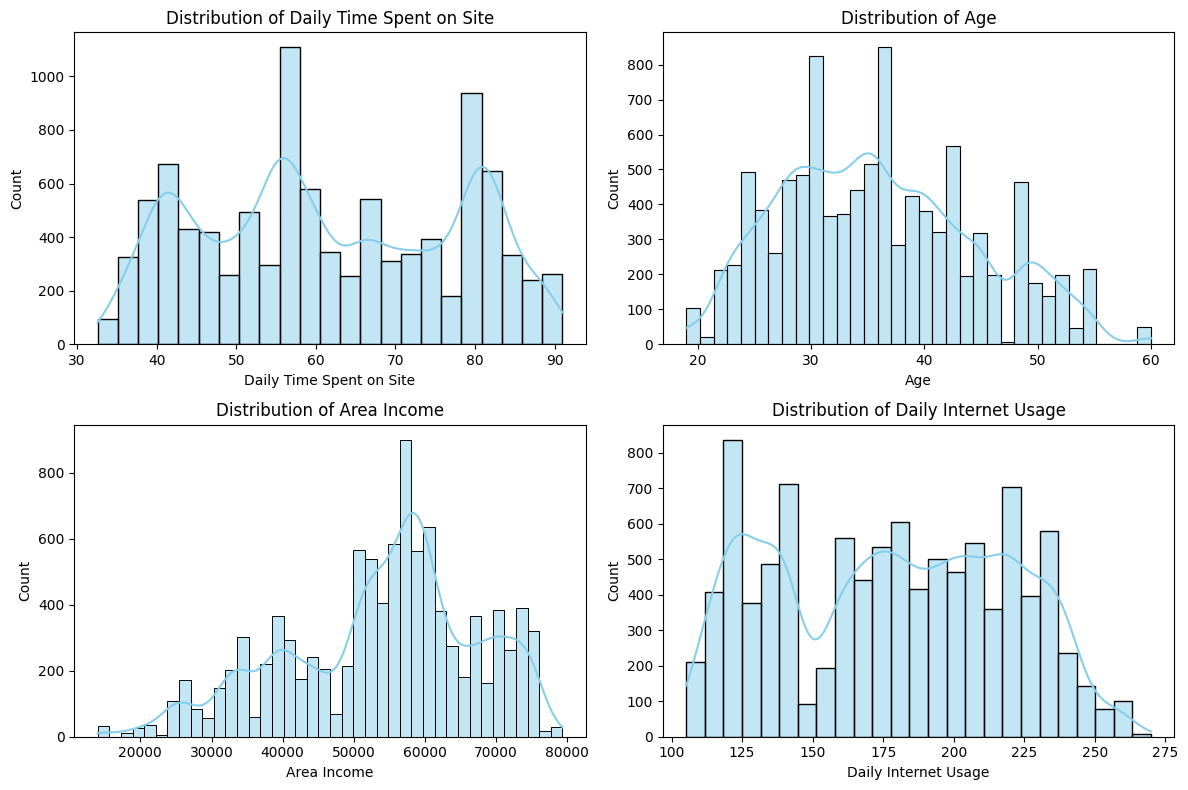

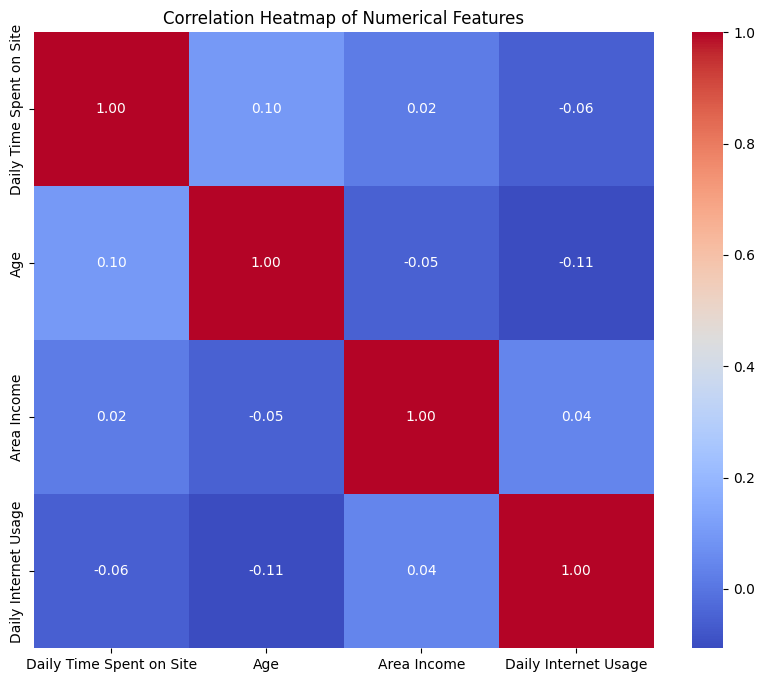

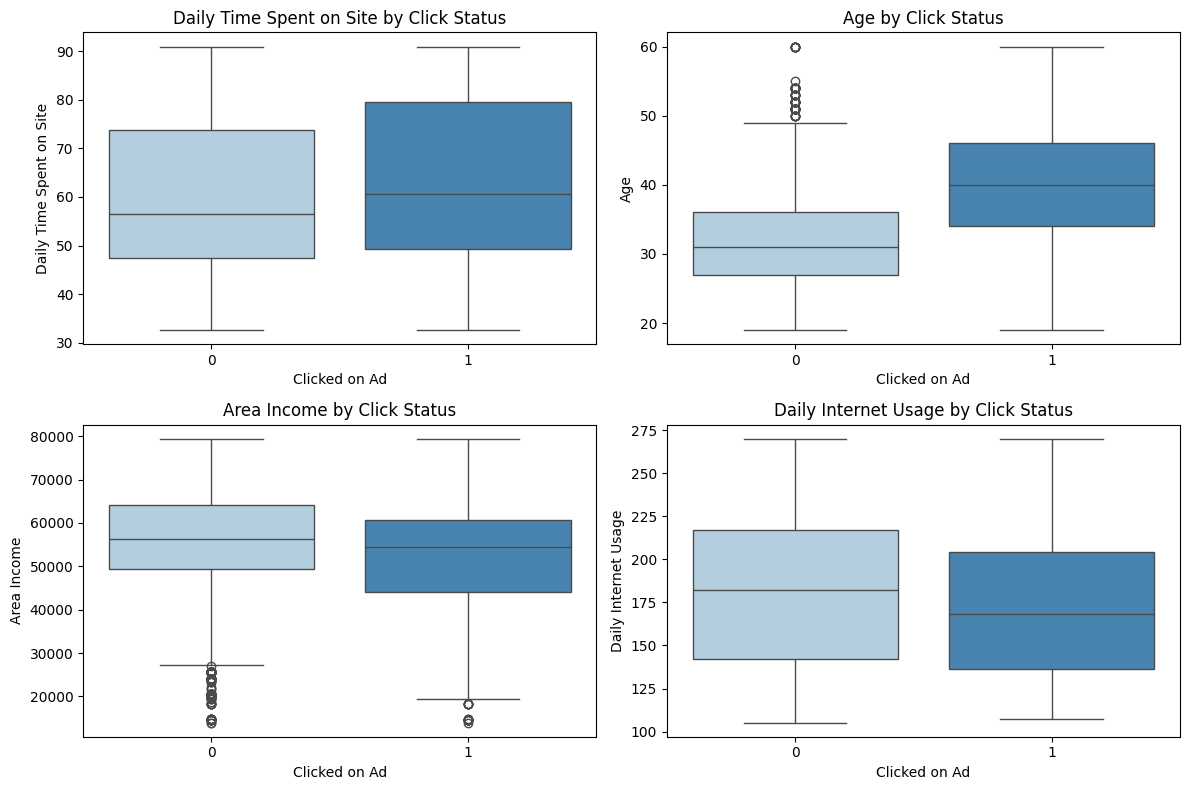

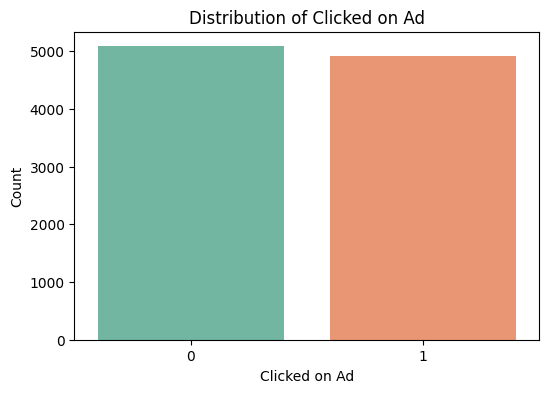

In [28]:
"""## Exploratory Data Analysis (EDA)"""

# Create output directory for EDA plots
os.makedirs("eda_plots", exist_ok=True)

# Histogram of numerical features
numerical_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig("eda_plots/numerical_histograms.png")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = data[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.savefig("eda_plots/correlation_heatmap.png")
plt.show()

# Box plot of numerical features by target
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Clicked on Ad', y=col, data=data, palette='Blues')
    plt.title(f'{col} by Click Status')
plt.tight_layout()
plt.savefig("eda_plots/box_plots.png")
plt.show()

# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Clicked on Ad', data=data, palette='Set2')
plt.title('Distribution of Clicked on Ad')
plt.xlabel('Clicked on Ad')
plt.ylabel('Count')
plt.savefig("eda_plots/target_distribution.png")
plt.show()


In [29]:
"""## Data Loading and Preprocessing"""

# Load the dataset
try:
    data = pd.read_csv('ad_records.csv')
except FileNotFoundError:
    print("Error: 'ad_records.csv' not found. Please provide a valid dataset.")
    exit(1)

# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Extract hour, day, and month
data['Hour'] = data['Timestamp'].dt.hour
data['Day'] = data['Timestamp'].dt.day
data['Month'] = data['Timestamp'].dt.month

# Store unique cities and countries
unique_cities = data['City'].unique()
unique_countries = data['Country'].unique()

# Encode categorical variables
label_encoders = {}
for col in ['City', 'Gender', 'Country']:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

# Feature selection
numerical_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Hour', 'Day', 'Month']
X = data[numerical_cols]
y = data['Clicked on Ad']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Calculate click-through rate
click_through_rate = y.mean() * 100
print(f"The click-through rate is: {click_through_rate:.2f}%")

The click-through rate is: 49.17%


In [30]:

"""## Model Training and Hyperparameter Tuning"""

# Initialize lists for results and ROC curves
model_results = []
roc_curves = []

# XGBoost
print("\nTraining XGBoost...")
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_
print(f"Best parameters for XGBoost: {xgb_grid_search.best_params_}")

# Cross-validation
xgb_cv_scores = cross_val_score(xgb_best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"XGBoost Cross-Validation Accuracy: {xgb_cv_scores.mean():.2f} ± {xgb_cv_scores.std():.2f}")

# Evaluate
xgb_y_pred = xgb_best_model.predict(X_test)
xgb_y_proba = xgb_best_model.predict_proba(X_test)[:, 1]
xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, xgb_y_pred),
    'Precision': precision_score(y_test, xgb_y_pred),
    'Recall': recall_score(y_test, xgb_y_pred),
    'F1-Score': f1_score(y_test, xgb_y_pred),
    'AUC': roc_auc_score(y_test, xgb_y_proba),
    'CV Accuracy': xgb_cv_scores.mean()
}
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_y_pred))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, xgb_y_pred))
model_results.append(xgb_metrics)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_proba)
roc_curves.append((xgb_fpr, xgb_tpr, xgb_metrics['AUC'], 'XGBoost'))
joblib.dump(xgb_best_model, 'xgboost_model.pkl')


Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200}
XGBoost Cross-Validation Accuracy: 0.83 ± 0.01

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1014
           1       0.84      0.85      0.84       986

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

XGBoost Confusion Matrix:
[[859 155]
 [152 834]]


['xgboost_model.pkl']

In [31]:
# Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_
print(f"Best parameters for Random Forest: {rf_grid_search.best_params_}")

# Cross-validation
rf_cv_scores = cross_val_score(rf_best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Random Forest Cross-Validation Accuracy: {rf_cv_scores.mean():.2f} ± {rf_cv_scores.std():.2f}")

# Evaluate
rf_y_pred = rf_best_model.predict(X_test)
rf_y_proba = rf_best_model.predict_proba(X_test)[:, 1]
rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, rf_y_pred),
    'Precision': precision_score(y_test, rf_y_pred),
    'Recall': recall_score(y_test, rf_y_pred),
    'F1-Score': f1_score(y_test, rf_y_pred),
    'AUC': roc_auc_score(y_test, rf_y_proba),
    'CV Accuracy': rf_cv_scores.mean()
}
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_y_pred))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_y_pred))
model_results.append(rf_metrics)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_proba)
roc_curves.append((rf_fpr, rf_tpr, rf_metrics['AUC'], 'Random Forest'))
joblib.dump(rf_best_model, 'random_forest_model.pkl')


Training Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Cross-Validation Accuracy: 0.82 ± 0.01

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1014
           1       0.84      0.82      0.83       986

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

Random Forest Confusion Matrix:
[[860 154]
 [182 804]]


['random_forest_model.pkl']

In [32]:


# Logistic Regression
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(random_state=42)
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}
lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid_search.fit(X_train, y_train)
lr_best_model = lr_grid_search.best_estimator_
print(f"Best parameters for Logistic Regression: {lr_grid_search.best_params_}")

# Cross-validation
lr_cv_scores = cross_val_score(lr_best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Logistic Regression Cross-Validation Accuracy: {lr_cv_scores.mean():.2f} ± {lr_cv_scores.std():.2f}")

# Evaluate
lr_y_pred = lr_best_model.predict(X_test)
lr_y_proba = lr_best_model.predict_proba(X_test)[:, 1]
lr_metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, lr_y_pred),
    'Precision': precision_score(y_test, lr_y_pred),
    'Recall': recall_score(y_test, lr_y_pred),
    'F1-Score': f1_score(y_test, lr_y_pred),
    'AUC': roc_auc_score(y_test, lr_y_proba),
    'CV Accuracy': lr_cv_scores.mean()
}
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_y_pred))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, lr_y_pred))
model_results.append(lr_metrics)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_y_proba)
roc_curves.append((lr_fpr, lr_tpr, lr_metrics['AUC'], 'Logistic Regression'))
joblib.dump(lr_best_model, 'logistic_regression_model.pkl')



Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression Cross-Validation Accuracy: 0.73 ± 0.01

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      1014
           1       0.75      0.67      0.71       986

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000

Logistic Regression Confusion Matrix:
[[794 220]
 [322 664]]


['logistic_regression_model.pkl']

In [33]:


# Model comparison
results_df = pd.DataFrame(model_results)
print("\nModel Comparison:")
print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC', 'CV Accuracy']])

# Identify best model
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
print(f"\nBest Model based on Test Accuracy: {best_model_name}")


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score       AUC  \
0              XGBoost    0.8465   0.843276  0.845842  0.844557  0.923087   
1        Random Forest    0.8320   0.839248  0.815416  0.827160  0.911722   
2  Logistic Regression    0.7290   0.751131  0.673428  0.710160  0.777938   

   CV Accuracy  
0     0.834625  
1     0.821500  
2     0.728625  

Best Model based on Test Accuracy: XGBoost


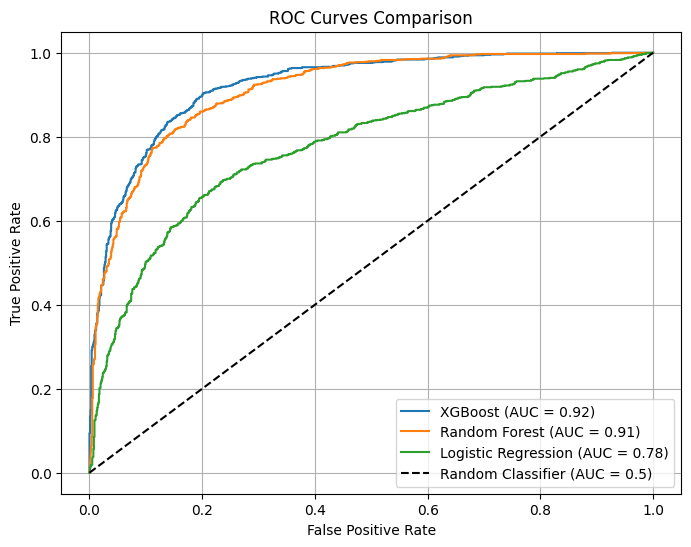

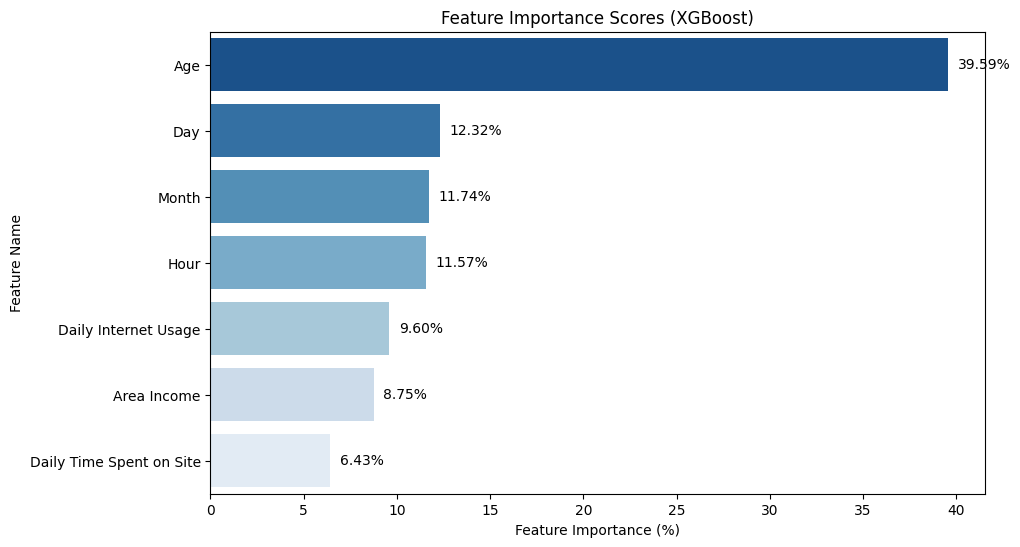

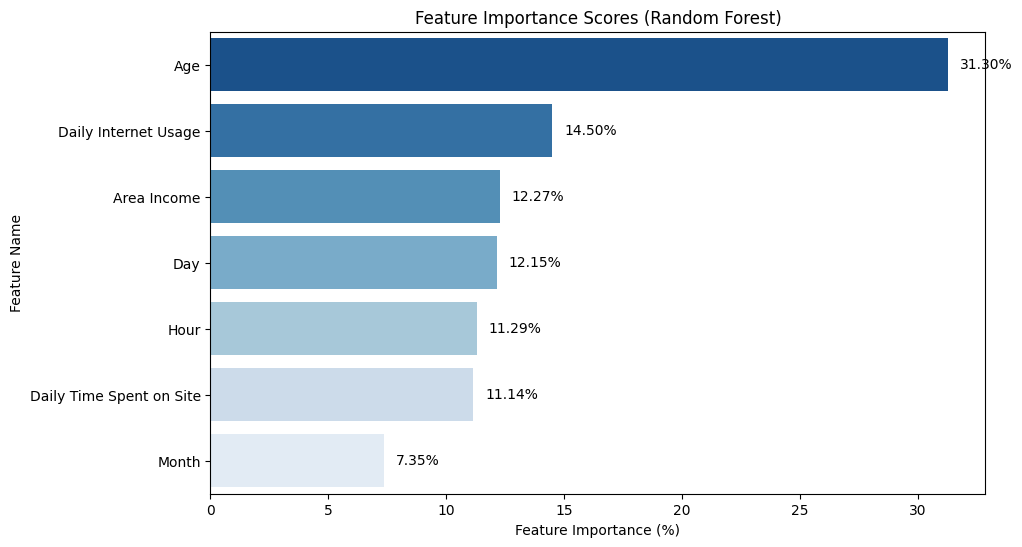

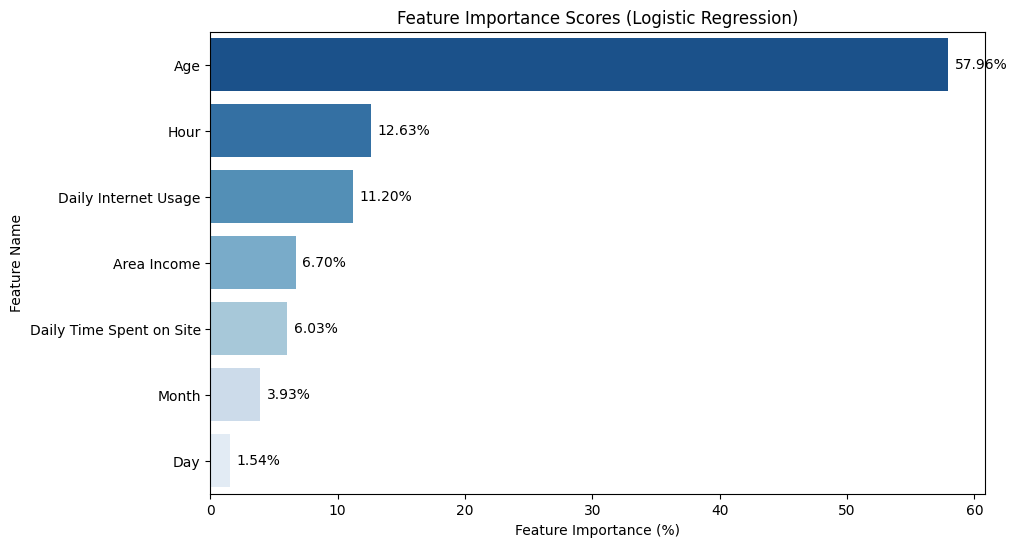

In [34]:
"""## Visualizations"""

# ROC curves
plt.figure(figsize=(8, 6))
for fpr, tpr, auc, model_name in roc_curves:
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('eda_plots/roc_curves.png')
plt.show()

# Feature importance for XGBoost
xgb_importances = xgb_best_model.feature_importances_
xgb_total = sum(xgb_importances)
xgb_percentage_importances = (xgb_importances / xgb_total) * 100
xgb_df = pd.DataFrame({'feature': numerical_cols, 'importance': xgb_percentage_importances}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=xgb_df, palette='Blues_r')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Name')
plt.title('Feature Importance Scores (XGBoost)')
for i, v in enumerate(xgb_df['importance']):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center')
plt.savefig('eda_plots/feature_importance_xgboost.png')
plt.show()

# Feature importance for Random Forest
rf_importances = rf_best_model.feature_importances_
rf_total = sum(rf_importances)
rf_percentage_importances = (rf_importances / rf_total) * 100
rf_df = pd.DataFrame({'feature': numerical_cols, 'importance': rf_percentage_importances}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=rf_df, palette='Blues_r')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Name')
plt.title('Feature Importance Scores (Random Forest)')
for i, v in enumerate(rf_df['importance']):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center')
plt.savefig('eda_plots/feature_importance_random_forest.png')
plt.show()

# Feature importance for Logistic Regression
lr_importances = np.abs(lr_best_model.coef_[0])
lr_total = sum(lr_importances)
lr_percentage_importances = (lr_importances / lr_total) * 100
lr_df = pd.DataFrame({'feature': numerical_cols, 'importance': lr_percentage_importances}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=lr_df, palette='Blues_r')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Name')
plt.title('Feature Importance Scores (Logistic Regression)')
for i, v in enumerate(lr_df['importance']):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center')
plt.savefig('eda_plots/feature_importance_logistic_regression.png')
plt.show()

In [40]:
import numpy as np
import pandas as pd
from faker import Faker
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Initialize Faker for synthetic data
fake = Faker()
Faker.seed(42)  # For reproducibility
np.random.seed(42)

# Define sample categorical data (replace with actual lists if available)
unique_cities = ['Lake John', 'New James', 'Lake Deannaborough', 'Port Jennifer', 'Lake Michael']
unique_countries = ['Kazakhstan', 'Mozambique', 'Australia', 'Serbia', 'Luxembourg']
genders = ['Male', 'Female']

# Initialize label encoders and scaler
label_encoders = {
    'City': LabelEncoder().fit(unique_cities),
    'Gender': LabelEncoder().fit(genders),
    'Country': LabelEncoder().fit(unique_countries)
}
numerical_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Hour', 'Day', 'Month']
scaler = StandardScaler()

# Generate synthetic data
n_samples = 1000
synthetic_data = pd.DataFrame({
    'Daily Time Spent on Site': np.random.normal(70, 20, n_samples).clip(20, 120),  # Normal distribution, clipped
    'Age': np.random.randint(18, 65, n_samples),
    'Area Income': np.random.lognormal(mean=10.5, sigma=0.5, size=n_samples).clip(15000, 100000),  # Log-normal for income
    'Daily Internet Usage': np.random.normal(150, 50, n_samples).clip(50, 300),  # Normal distribution, clipped
    'City': [fake.random_element(unique_cities) for _ in range(n_samples)],
    'Gender': [fake.random_element(genders) for _ in range(n_samples)],
    'Country': [fake.random_element(unique_countries) for _ in range(n_samples)],
    'Timestamp': [fake.date_time_this_year() for _ in range(n_samples)]
})

# Preprocess synthetic data
synthetic_data['Timestamp'] = pd.to_datetime(synthetic_data['Timestamp'])
synthetic_data['Hour'] = synthetic_data['Timestamp'].dt.hour
synthetic_data['Day'] = synthetic_data['Timestamp'].dt.day
synthetic_data['Month'] = synthetic_data['Timestamp'].dt.month

# Encode categorical variables
for col in ['City', 'Gender', 'Country']:
    try:
        synthetic_data[col] = label_encoders[col].transform(synthetic_data[col])
    except ValueError as e:
        print(f"Error encoding {col}: {e}")
        raise

# Scale numerical features
try:
    synthetic_X = synthetic_data[numerical_cols]
    synthetic_X_scaled = scaler.fit_transform(synthetic_X)  # Fit scaler on synthetic data (or load pre-trained scaler)
except KeyError as e:
    print(f"Error: Numerical columns {e} not found in synthetic data")
    raise

# Generate synthetic labels independently (rule-based for realism)
# Example: Click if high time spent, high income, and younger age
synthetic_data['Clicked on Ad'] = (
    (synthetic_data['Daily Time Spent on Site'] > 80) &
    (synthetic_data['Area Income'] > 50000) &
    (synthetic_data['Age'] < 40)
).astype(int)

# Load the pre-trained model
best_model_name = 'XGBoost'
try:
    best_model = joblib.load(f"{best_model_name.lower().replace(' ', '_')}_model.pkl")
except FileNotFoundError:
    print(f"Error: Model file {best_model_name.lower().replace(' ', '_')}_model.pkl not found")
    raise

# Predict on synthetic data
try:
    y_synthetic_pred = best_model.predict(synthetic_X_scaled)
except Exception as e:
    print(f"Error during prediction: {e}")
    raise

# Evaluate on synthetic data
accuracy_synthetic = accuracy_score(synthetic_data['Clicked on Ad'], y_synthetic_pred)
precision_synthetic = precision_score(synthetic_data['Clicked on Ad'], y_synthetic_pred)
recall_synthetic = recall_score(synthetic_data['Clicked on Ad'], y_synthetic_pred)
f1_synthetic = f1_score(synthetic_data['Clicked on Ad'], y_synthetic_pred)

print(f"Evaluation on Synthetic Data (using {best_model_name}):")
print(f"Accuracy: {accuracy_synthetic:.4f}")
print(f"Precision: {precision_synthetic:.4f}")
print(f"Recall: {recall_synthetic:.4f}")
print(f"F1-Score: {f1_synthetic:.4f}")

# Decode categorical variables for display
for col in ['City', 'Gender', 'Country']:
    try:
        synthetic_data[col] = label_encoders[col].inverse_transform(synthetic_data[col])
    except ValueError as e:
        print(f"Error decoding {col}: {e}")
        raise

# Display synthetic data
synthetic_data['Predictions'] = y_synthetic_pred
print("\nSynthetic Data Sample:")
print(synthetic_data.head())

# Optional: Save synthetic data for further analysis
synthetic_data.to_csv('synthetic_data.csv', index=False)

Evaluation on Synthetic Data (using XGBoost):
Accuracy: 0.4650
Precision: 0.0306
Recall: 0.3636
F1-Score: 0.0564

Synthetic Data Sample:
   Daily Time Spent on Site  Age   Area Income  Daily Internet Usage  \
0                 79.934283   61  38965.936620            173.681604   
1                 67.234714   57  15000.000000            103.680944   
2                 82.953771   28  42684.189319            177.775632   
3                100.460597   20  33731.881471            104.065674   
4                 65.316933   23  28766.930190            129.131659   

                 City  Gender     Country                  Timestamp  Hour  \
0           Lake John  Female      Serbia 2025-04-17 05:42:01.077669     5   
1           Lake John  Female      Serbia 2025-01-25 04:51:51.052758     4   
2  Lake Deannaborough  Female      Serbia 2025-04-18 05:53:18.191769     5   
3           New James    Male  Mozambique 2025-05-08 11:58:21.683799    11   
4           New James  Female   Australi